In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [8]:

# ======================================================
# 1. Device Setup
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
# ======================================================
# 2. Synthetic White Noise with Fixed Lag
# ======================================================
def generate_batch(batch_size, seq_len, tau, obs_noise=0.05):
    x = torch.randn(batch_size, seq_len)
    y = torch.roll(x, shifts=tau, dims=1)
    y[:, :tau] = 0.0  # prevent wraparound leakage
    y = y + obs_noise * torch.randn_like(y)
    return x.unsqueeze(-1), y.unsqueeze(-1)

In [10]:
# ======================================================
# 3. Transformer Model Setup
# ======================================================
seq_len = 50
tau = 5
batch_size = 64
n_batches = 3000
d_model = 64
nhead = 4
num_layers = 2

encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers).to(device)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers).to(device)
in_proj = nn.Linear(1, d_model).to(device)
out_proj = nn.Linear(d_model, 1).to(device)

optimizer = optim.Adam(
    list(encoder.parameters()) +
    list(decoder.parameters()) +
    list(in_proj.parameters()) +
    list(out_proj.parameters()),
    lr=1e-3
)
loss_fn = nn.MSELoss()

In [11]:
loss_history = []  # <--- Add this before training

In [12]:
# ======================================================
# 4. Training Loop with Loss Tracking
# ======================================================
loss_history = []

print("Training...")
for step in range(n_batches):
    x, y = generate_batch(batch_size, seq_len, tau)
    x = x.to(device)
    y = y.to(device)

    x_emb = in_proj(x)
    y_emb = in_proj(y)

    mem = encoder(x_emb)
    out = decoder(y_emb, mem)
    y_pred = out_proj(out)

    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (step + 1) % 500 == 0:
        print(f"Step {step+1}/{n_batches}, Loss: {loss.item():.6f}")

Training...
Step 500/3000, Loss: 0.002304
Step 1000/3000, Loss: 0.001065
Step 1500/3000, Loss: 0.000830
Step 2000/3000, Loss: 0.000561
Step 2500/3000, Loss: 0.000629
Step 3000/3000, Loss: 0.000294


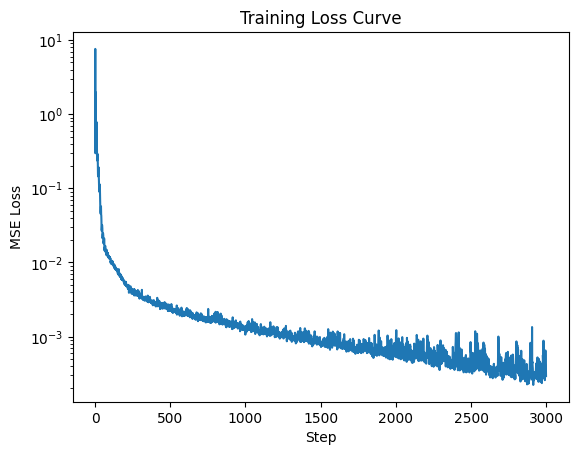

In [13]:
# Plot training curve
plt.figure()
plt.plot(loss_history)
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.title("Training Loss Curve")
plt.show()

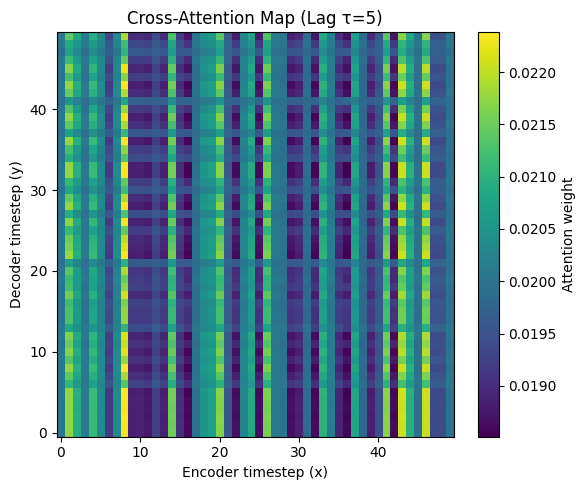

In [19]:
# Switch to eval mode to freeze dropout etc.
encoder.eval()
decoder.eval()

# Generate a single test example
x, y = generate_batch(1, seq_len, tau)
x = x.to(device)
y = y.to(device)

x_emb = in_proj(x)
y_emb = in_proj(y)

# Run encoder
mem = encoder(x_emb)

# ---- CRITICAL PART ----
# Grab first decoder layer
layer = decoder.layers[0]

# 1️⃣ Self-attention to get proper decoder queries
tgt = y_emb
tgt2 = layer.self_attn(tgt, tgt, tgt, need_weights=False)[0]
tgt = layer.norm1(tgt + layer.dropout1(tgt2))

# 2️⃣ Cross-attention with these queries
tgt2, attn = layer.multihead_attn(
    tgt, mem, mem,
    need_weights=True,
    average_attn_weights=True  # (B, T_dec, T_enc)
)

# 3️⃣ Plot attention map
attn_map = attn[0].detach().cpu().numpy()
plt.figure(figsize=(6, 5))
plt.imshow(attn_map, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Attention weight')
plt.xlabel('Encoder timestep (x)')
plt.ylabel('Decoder timestep (y)')
plt.title(f'Cross-Attention Map (Lag τ={tau})')
plt.tight_layout()
plt.show()


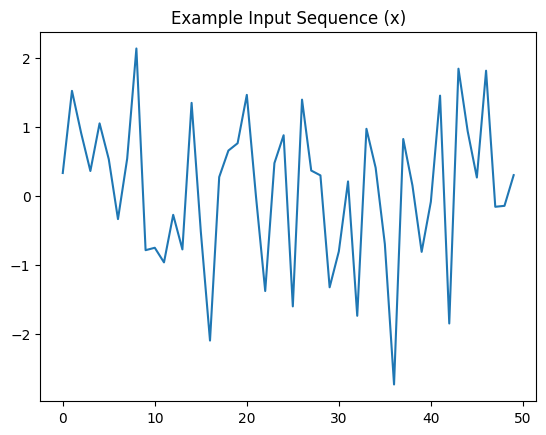

In [20]:
# Optional: plot one example of the input signal to verify it's white noise
plt.figure()
plt.plot(x[0].detach().cpu().numpy())
plt.title("Example Input Sequence (x)")
plt.show()

Using device: cuda
Step 500/2000, Loss: 0.267994
Step 1000/2000, Loss: 0.047381
Step 1500/2000, Loss: 0.017295
Step 2000/2000, Loss: 0.011455


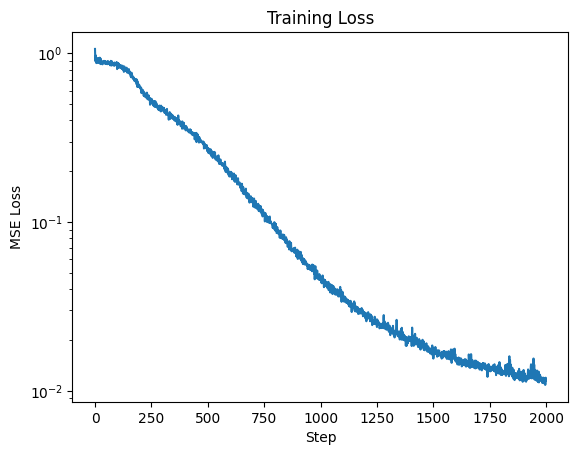

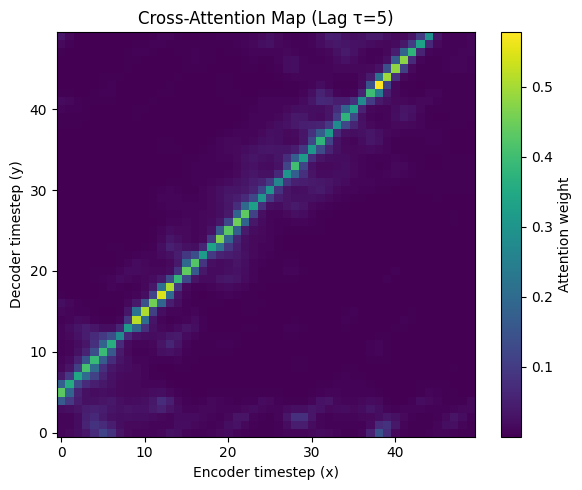

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ===========================================
# Setup
# ===========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

T = 50      # sequence length
tau = 5     # lag
d_model = 64
n_heads = 4
n_steps = 2000
batch_size = 128

# ===========================================
# Synthetic Data Generator
# ===========================================
def generate_batch(batch_size, T, tau, obs_noise=0.05):
    x = torch.randn(batch_size, T)
    y = torch.roll(x, shifts=tau, dims=1)
    y[:, :tau] = 0.0
    y = y + obs_noise * torch.randn_like(y)
    return x.unsqueeze(-1), y.unsqueeze(-1)

# ===========================================
# Positional Encoding
# ===========================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, T, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

pos_enc = PositionalEncoding(d_model).to(device)

# ===========================================
# Minimal Cross-Attention Model
# ===========================================
class LagAttentionModel(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.in_proj = nn.Linear(1, d_model)
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.out_proj = nn.Linear(d_model, 1)

    def forward(self, x, y_query):
        # x: encoder input, y_query: decoder query (here, zero vectors)
        x_emb = pos_enc(self.in_proj(x))
        y_emb = pos_enc(self.in_proj(y_query))
        attn_out, attn_weights = self.attn(y_emb, x_emb, x_emb, need_weights=True, average_attn_weights=True)
        out = self.out_proj(attn_out)
        return out, attn_weights

model = LagAttentionModel(d_model, n_heads).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ===========================================
# Training
# ===========================================
loss_history = []
for step in range(n_steps):
    x, y = generate_batch(batch_size, T, tau)
    x, y = x.to(device), y.to(device)
    y_query = torch.zeros_like(y)  # decoder starts with zeros

    y_pred, _ = model(x, y_query)
    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (step+1) % 500 == 0:
        print(f"Step {step+1}/{n_steps}, Loss: {loss.item():.6f}")

# Plot loss
plt.figure()
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# ===========================================
# Visualization
# ===========================================
x_test, y_test = generate_batch(1, T, tau)
x_test, y_test = x_test.to(device), y_test.to(device)
y_query = torch.zeros_like(y_test)

with torch.no_grad():
    y_pred, attn_weights = model(x_test, y_query)

attn_map = attn_weights[0].cpu().numpy()  # shape (T_dec, T_enc)
plt.figure(figsize=(6, 5))
plt.imshow(attn_map, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Attention weight')
plt.xlabel('Encoder timestep (x)')
plt.ylabel('Decoder timestep (y)')
plt.title(f'Cross-Attention Map (Lag τ={tau})')
plt.tight_layout()
plt.show()

Using device: cuda
Training...
Step 500/3000, Loss: 0.888971
Step 1000/3000, Loss: 0.885571
Step 1500/3000, Loss: 0.885623
Step 2000/3000, Loss: 0.889100
Step 2500/3000, Loss: 0.877163
Step 3000/3000, Loss: 0.931848


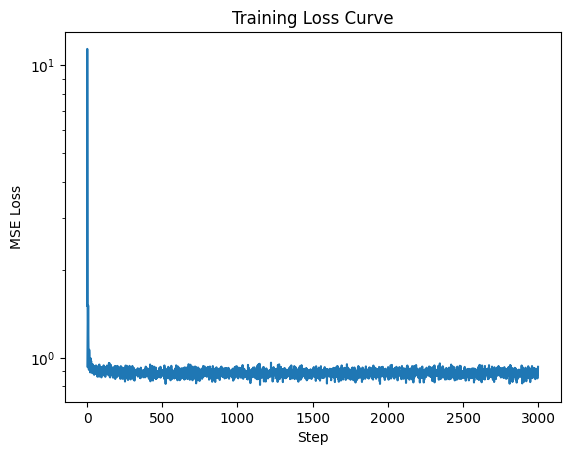

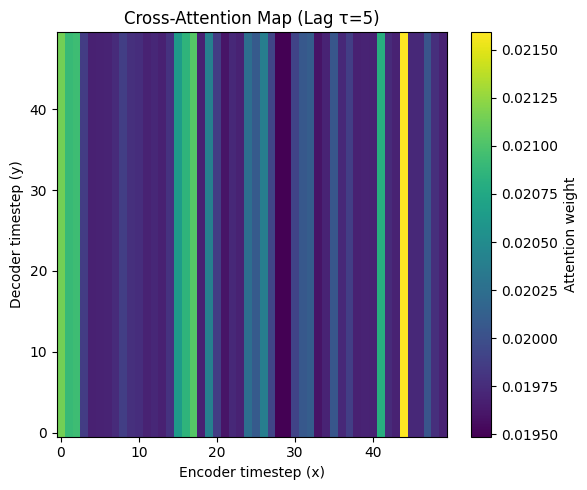

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ======================================================
# 1. Device Setup
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ======================================================
# 2. Synthetic Data Generator (White Noise)
# ======================================================
def generate_batch(batch_size, seq_len, tau, obs_noise=0.05):
    x = torch.randn(batch_size, seq_len)
    y = torch.roll(x, shifts=tau, dims=1)
    y[:, :tau] = 0.0
    y = y + obs_noise * torch.randn_like(y)
    return x.unsqueeze(-1), y.unsqueeze(-1)

# ======================================================
# 3. Transformer Encoder–Decoder Model
# ======================================================
seq_len = 50
tau = 5
batch_size = 64
n_batches = 3000
d_model = 64
nhead = 4
num_layers = 2

encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers).to(device)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers).to(device)
in_proj = nn.Linear(1, d_model).to(device)
out_proj = nn.Linear(d_model, 1).to(device)

optimizer = optim.Adam(
    list(encoder.parameters()) +
    list(decoder.parameters()) +
    list(in_proj.parameters()) +
    list(out_proj.parameters()),
    lr=1e-3
)
loss_fn = nn.MSELoss()

# ======================================================
# 4. Training Loop (Zero Decoder Queries)
# ======================================================
loss_history = []

print("Training...")
for step in range(n_batches):
    x, y = generate_batch(batch_size, seq_len, tau)
    x = x.to(device)
    y = y.to(device)

    # Encoder input
    x_emb = in_proj(x)

    # 🚨 CHANGE: Decoder queries are zero, not ground-truth y
    y_emb = torch.zeros_like(x)
    y_emb = in_proj(y_emb)

    mem = encoder(x_emb)
    out = decoder(y_emb, mem)
    y_pred = out_proj(out)

    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (step + 1) % 500 == 0:
        print(f"Step {step+1}/{n_batches}, Loss: {loss.item():.6f}")

# Plot training curve
plt.figure()
plt.plot(loss_history)
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.title("Training Loss Curve")
plt.show()

# ======================================================
# 5. Cross-Attention Visualization
# ======================================================
encoder.eval()
decoder.eval()

x_test, y_test = generate_batch(1, seq_len, tau)
x_test = x_test.to(device)
y_test = y_test.to(device)

x_emb = in_proj(x_test)
y_emb = torch.zeros_like(x_test)
y_emb = in_proj(y_emb)

mem = encoder(x_emb)

# Extract cross-attention from first decoder layer
layer = decoder.layers[0]

# Decoder self-attention to form queries
tgt = y_emb
tgt2 = layer.self_attn(tgt, tgt, tgt, need_weights=False)[0]
tgt = layer.norm1(tgt + layer.dropout1(tgt2))

# Cross-attention
tgt2, attn = layer.multihead_attn(
    tgt, mem, mem,
    need_weights=True,
    average_attn_weights=True
)

attn_map = attn[0].detach().cpu().numpy()
plt.figure(figsize=(6, 5))
plt.imshow(attn_map, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Attention weight')
plt.xlabel('Encoder timestep (x)')
plt.ylabel('Decoder timestep (y)')
plt.title(f'Cross-Attention Map (Lag τ={tau})')
plt.tight_layout()
plt.show()

Using device: cuda
Training...
Step 500/3000, Loss: 0.002873
Step 1000/3000, Loss: 0.002024
Step 1500/3000, Loss: 0.001165
Step 2000/3000, Loss: 0.000931
Step 2500/3000, Loss: 0.000780
Step 3000/3000, Loss: 0.000483


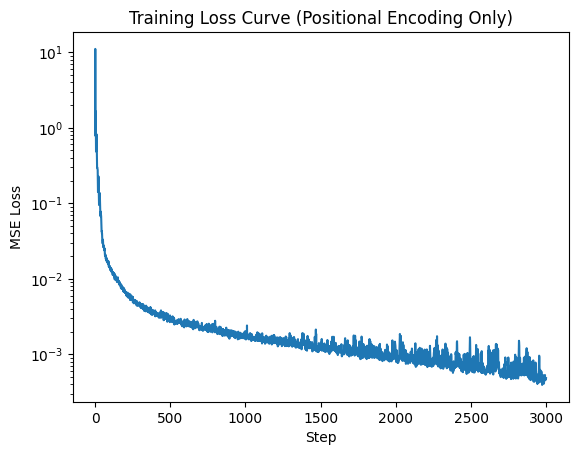

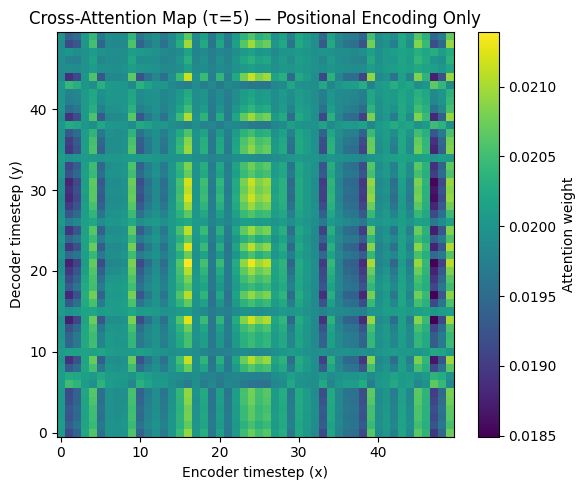

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ======================================================
# 1. Device Setup
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ======================================================
# 2. Synthetic Data Generator (White Noise)
# ======================================================
def generate_batch(batch_size, seq_len, tau, obs_noise=0.05):
    x = torch.randn(batch_size, seq_len)
    y = torch.roll(x, shifts=tau, dims=1)
    y[:, :tau] = 0.0
    y = y + obs_noise * torch.randn_like(y)
    return x.unsqueeze(-1), y.unsqueeze(-1)

# ======================================================
# 3. Positional Encoding
# ======================================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# ======================================================
# 4. Transformer Model
# ======================================================
seq_len = 50
tau = 5
batch_size = 64
n_batches = 3000
d_model = 64
nhead = 4
num_layers = 2

encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers).to(device)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers).to(device)
in_proj = nn.Linear(1, d_model).to(device)
out_proj = nn.Linear(d_model, 1).to(device)
pos_enc = PositionalEncoding(d_model).to(device)

optimizer = optim.Adam(
    list(encoder.parameters()) +
    list(decoder.parameters()) +
    list(in_proj.parameters()) +
    list(out_proj.parameters()),
    lr=1e-3
)
loss_fn = nn.MSELoss()

# ======================================================
# 5. Training Loop (Teacher Forcing + Positional Encoding)
# ======================================================
loss_history = []
print("Training...")
for step in range(n_batches):
    x, y = generate_batch(batch_size, seq_len, tau)
    x = x.to(device)
    y = y.to(device)

    x_emb = pos_enc(in_proj(x))   # Positional encoding on encoder
    y_emb = pos_enc(in_proj(y))   # Positional encoding on decoder (teacher forcing)

    mem = encoder(x_emb)
    out = decoder(y_emb, mem)
    y_pred = out_proj(out)

    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (step + 1) % 500 == 0:
        print(f"Step {step+1}/{n_batches}, Loss: {loss.item():.6f}")

plt.figure()
plt.plot(loss_history)
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.title("Training Loss Curve (Positional Encoding Only)")
plt.show()

# ======================================================
# 6. Cross-Attention Visualization
# ======================================================
encoder.eval()
decoder.eval()

x_test, y_test = generate_batch(1, seq_len, tau)
x_test = x_test.to(device)
y_test = y_test.to(device)

x_emb = pos_enc(in_proj(x_test))
y_emb = pos_enc(in_proj(y_test))

mem = encoder(x_emb)

layer = decoder.layers[0]

# Self-attention to form queries
tgt = y_emb
tgt2 = layer.self_attn(tgt, tgt, tgt, need_weights=False)[0]
tgt = layer.norm1(tgt + layer.dropout1(tgt2))

# Cross-attention weights
tgt2, attn = layer.multihead_attn(
    tgt, mem, mem,
    need_weights=True,
    average_attn_weights=True
)

attn_map = attn[0].detach().cpu().numpy()
plt.figure(figsize=(6, 5))
plt.imshow(attn_map, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Attention weight')
plt.xlabel('Encoder timestep (x)')
plt.ylabel('Decoder timestep (y)')
plt.title(f'Cross-Attention Map (τ={tau}) — Positional Encoding Only')
plt.tight_layout()
plt.show()

Using device: cuda
Training...
Step 500/3000, Loss: 0.872329
Step 1000/3000, Loss: 0.736257
Step 1500/3000, Loss: 0.024715
Step 2000/3000, Loss: 0.034781
Step 2500/3000, Loss: 0.022957
Step 3000/3000, Loss: 0.013731


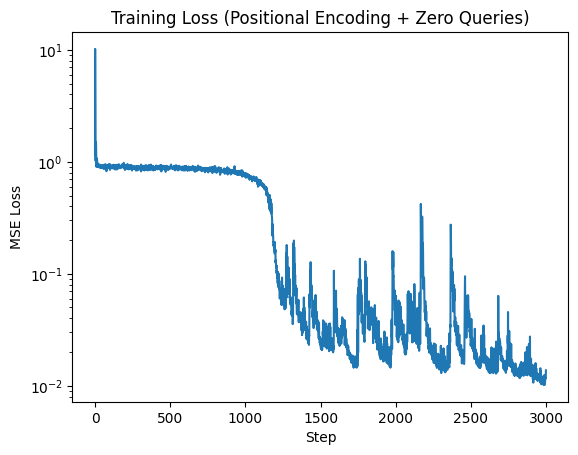

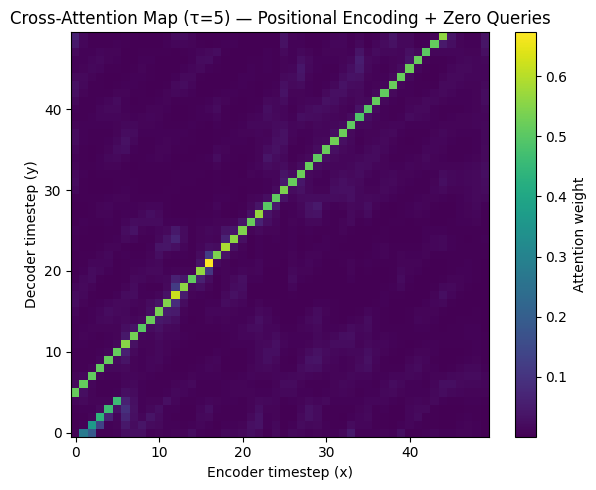

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ======================================================
# 1. Device Setup
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ======================================================
# 2. Synthetic Data Generator (White Noise with Fixed Lag)
# ======================================================
def generate_batch(batch_size, seq_len, tau, obs_noise=0.05):
    x = torch.randn(batch_size, seq_len)
    y = torch.roll(x, shifts=tau, dims=1)
    y[:, :tau] = 0.0
    y = y + obs_noise * torch.randn_like(y)
    return x.unsqueeze(-1), y.unsqueeze(-1)

# ======================================================
# 3. Positional Encoding
# ======================================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, T, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# ======================================================
# 4. Transformer Model Setup
# ======================================================
seq_len = 50
tau = 5
batch_size = 64
n_batches = 3000
d_model = 64
nhead = 4
num_layers = 2

encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers).to(device)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers).to(device)
in_proj = nn.Linear(1, d_model).to(device)
out_proj = nn.Linear(d_model, 1).to(device)
pos_enc = PositionalEncoding(d_model).to(device)

optimizer = optim.Adam(
    list(encoder.parameters()) +
    list(decoder.parameters()) +
    list(in_proj.parameters()) +
    list(out_proj.parameters()),
    lr=1e-3
)
loss_fn = nn.MSELoss()

# ======================================================
# 5. Training Loop
# ======================================================
loss_history = []
print("Training...")

for step in range(n_batches):
    x, y = generate_batch(batch_size, seq_len, tau)
    x = x.to(device)
    y = y.to(device)

    # Encoder input with positional encoding
    x_emb = pos_enc(in_proj(x))

    # Decoder queries: zeros + positional encoding
    y_zeros = torch.zeros_like(x)
    y_emb = pos_enc(in_proj(y_zeros))

    mem = encoder(x_emb)
    out = decoder(y_emb, mem)
    y_pred = out_proj(out)

    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (step + 1) % 500 == 0:
        print(f"Step {step+1}/{n_batches}, Loss: {loss.item():.6f}")

# Plot training curve
plt.figure()
plt.plot(loss_history)
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.title("Training Loss (Positional Encoding + Zero Queries)")
plt.show()

# ======================================================
# 6. Cross-Attention Visualization
# ======================================================
encoder.eval()
decoder.eval()

x_test, y_test = generate_batch(1, seq_len, tau)
x_test = x_test.to(device)
y_test = y_test.to(device)

x_emb = pos_enc(in_proj(x_test))
y_emb = pos_enc(in_proj(torch.zeros_like(x_test)))

mem = encoder(x_emb)

# Extract cross-attention from first decoder layer
layer = decoder.layers[0]

# Decoder self-attention to form queries
tgt = y_emb
tgt2 = layer.self_attn(tgt, tgt, tgt, need_weights=False)[0]
tgt = layer.norm1(tgt + layer.dropout1(tgt2))

# Cross-attention weights
tgt2, attn = layer.multihead_attn(
    tgt, mem, mem,
    need_weights=True,
    average_attn_weights=True
)

attn_map = attn[0].detach().cpu().numpy()
plt.figure(figsize=(6, 5))
plt.imshow(attn_map, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Attention weight')
plt.xlabel('Encoder timestep (x)')
plt.ylabel('Decoder timestep (y)')
plt.title(f'Cross-Attention Map (τ={tau}) — Positional Encoding + Zero Queries')
plt.tight_layout()
plt.show()

Using device: cuda
Training...
Step 500/3000, Loss: 0.004085
Step 1000/3000, Loss: 0.003369
Step 1500/3000, Loss: 0.003090
Step 2000/3000, Loss: 0.002821
Step 2500/3000, Loss: 0.002943
Step 3000/3000, Loss: 0.002848


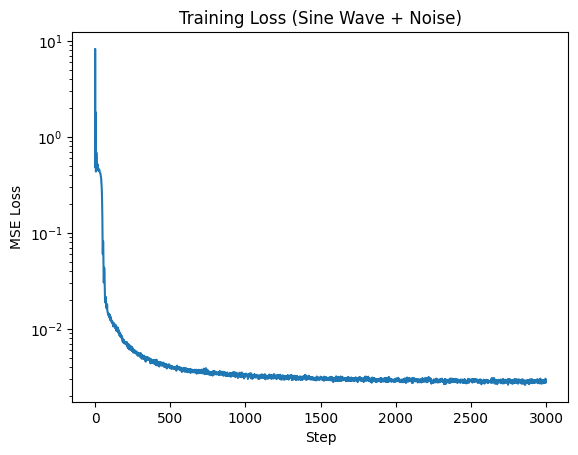

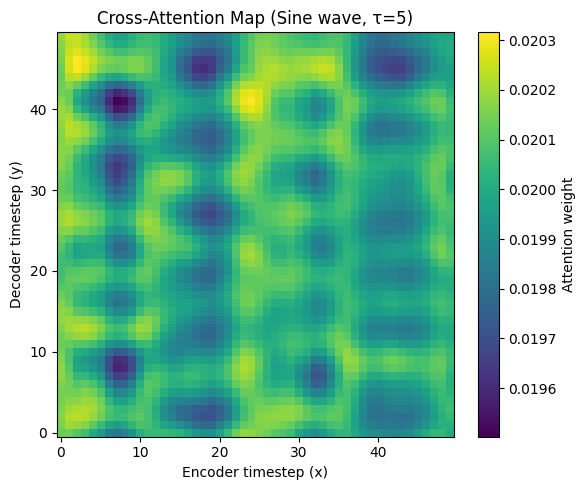

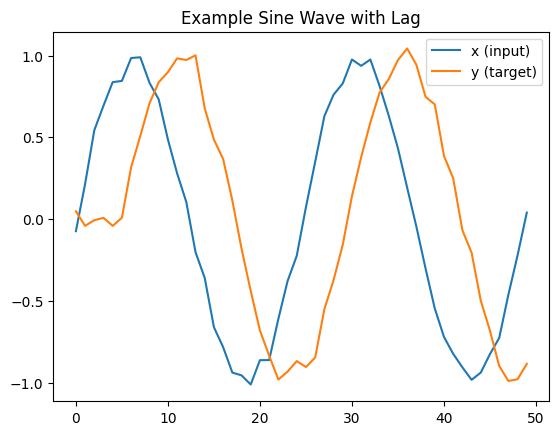

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

# ======================================================
# 1. Device Setup
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ======================================================
# 2. Synthetic Data Generator (Sine Wave + Optional Noise)
# ======================================================
def generate_batch(batch_size, seq_len, tau, freq=2.0, obs_noise=0.05):
    t = torch.linspace(0, 2 * math.pi, seq_len)
    x = torch.sin(freq * t).unsqueeze(0).repeat(batch_size, 1)
    y = torch.roll(x, shifts=tau, dims=1)
    y[:, :tau] = 0.0
    if obs_noise > 0:
        x = x + obs_noise * torch.randn_like(x)
        y = y + obs_noise * torch.randn_like(y)
    return x.unsqueeze(-1), y.unsqueeze(-1)

# ======================================================
# 3. Positional Encoding
# ======================================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# ======================================================
# 4. Transformer Model Setup
# ======================================================
seq_len = 50
tau = 5
batch_size = 64
n_batches = 3000
d_model = 64
nhead = 4
num_layers = 2

encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers).to(device)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers).to(device)
in_proj = nn.Linear(1, d_model).to(device)
out_proj = nn.Linear(d_model, 1).to(device)
pos_enc = PositionalEncoding(d_model).to(device)

optimizer = optim.Adam(
    list(encoder.parameters()) +
    list(decoder.parameters()) +
    list(in_proj.parameters()) +
    list(out_proj.parameters()),
    lr=1e-3
)
loss_fn = nn.MSELoss()

# ======================================================
# 5. Training Loop (Zero Queries + Positional Encoding)
# ======================================================
loss_history = []
print("Training...")

for step in range(n_batches):
    x, y = generate_batch(batch_size, seq_len, tau, freq=2.0, obs_noise=0.05)  # 🌊 sine wave with small noise
    x = x.to(device)
    y = y.to(device)

    x_emb = pos_enc(in_proj(x))
    y_zeros = torch.zeros_like(x)
    y_emb = pos_enc(in_proj(y_zeros))

    mem = encoder(x_emb)
    out = decoder(y_emb, mem)
    y_pred = out_proj(out)

    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (step + 1) % 500 == 0:
        print(f"Step {step+1}/{n_batches}, Loss: {loss.item():.6f}")

plt.figure()
plt.plot(loss_history)
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.title("Training Loss (Sine Wave + Noise)")
plt.show()

# ======================================================
# 6. Cross-Attention Visualization
# ======================================================
encoder.eval()
decoder.eval()

x_test, y_test = generate_batch(1, seq_len, tau, freq=2.0, obs_noise=0.05)
x_test = x_test.to(device)
y_test = y_test.to(device)

x_emb = pos_enc(in_proj(x_test))
y_emb = pos_enc(in_proj(torch.zeros_like(x_test)))

mem = encoder(x_emb)

layer = decoder.layers[0]
tgt = y_emb
tgt2 = layer.self_attn(tgt, tgt, tgt, need_weights=False)[0]
tgt = layer.norm1(tgt + layer.dropout1(tgt2))
tgt2, attn = layer.multihead_attn(
    tgt, mem, mem,
    need_weights=True,
    average_attn_weights=True
)

attn_map = attn[0].detach().cpu().numpy()
plt.figure(figsize=(6, 5))
plt.imshow(attn_map, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Attention weight')
plt.xlabel('Encoder timestep (x)')
plt.ylabel('Decoder timestep (y)')
plt.title(f'Cross-Attention Map (Sine wave, τ={tau})')
plt.tight_layout()
plt.show()

# Optional: visualize input/output
plt.figure()
plt.plot(x_test[0].cpu().numpy(), label='x (input)')
plt.plot(y_test[0].cpu().numpy(), label='y (target)')
plt.legend()
plt.title("Example Sine Wave with Lag")
plt.show()

Using device: cuda
Training with variable τ (white noise)...
Step 500/3000, Loss: 0.881002
Step 1000/3000, Loss: 0.833763
Step 1500/3000, Loss: 0.844004
Step 2000/3000, Loss: 0.825734
Step 2500/3000, Loss: 0.878208
Step 3000/3000, Loss: 0.849172


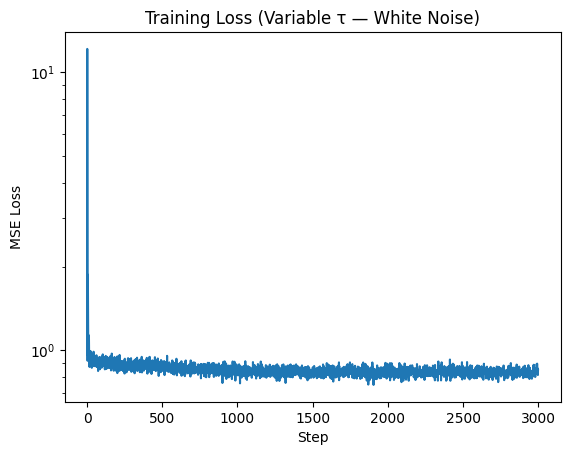

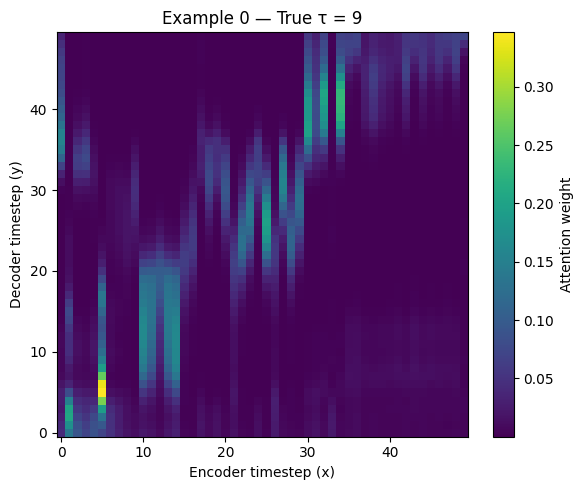

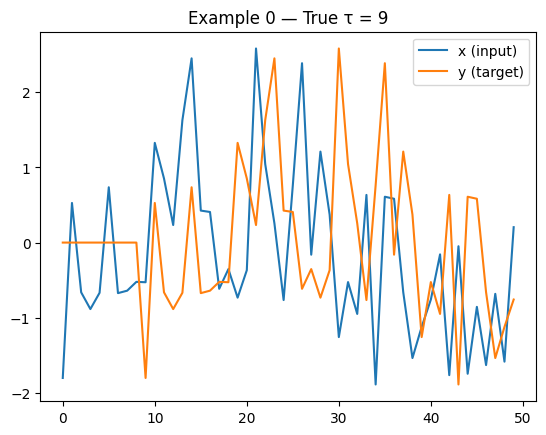

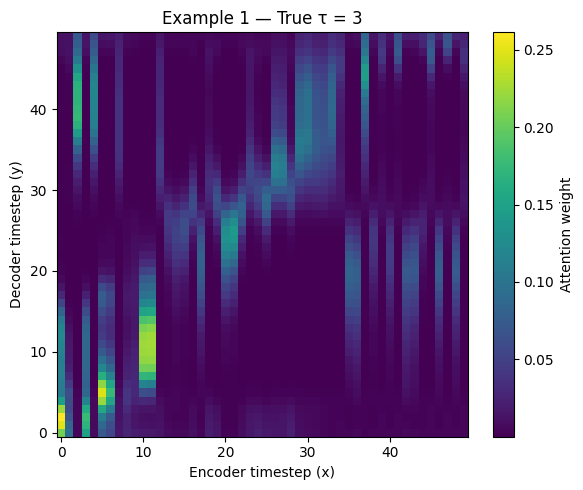

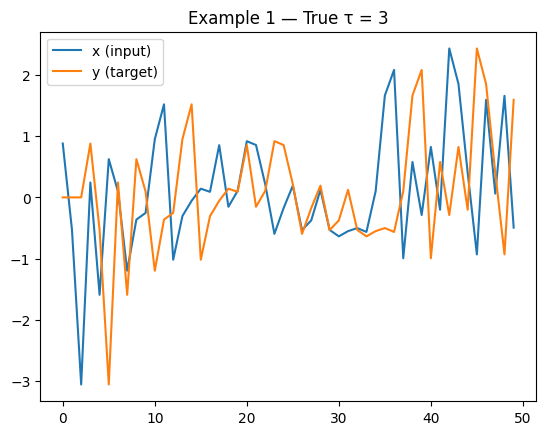

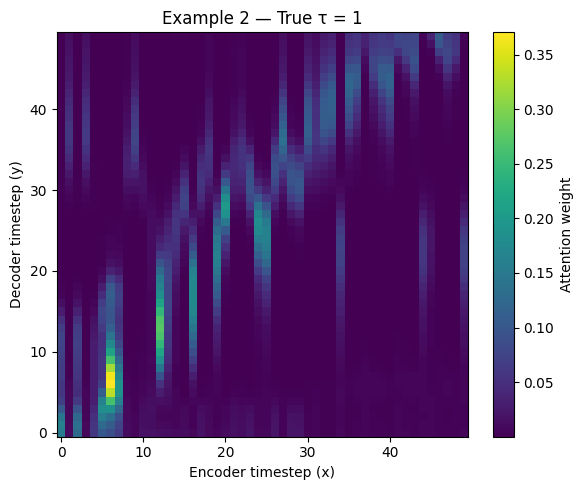

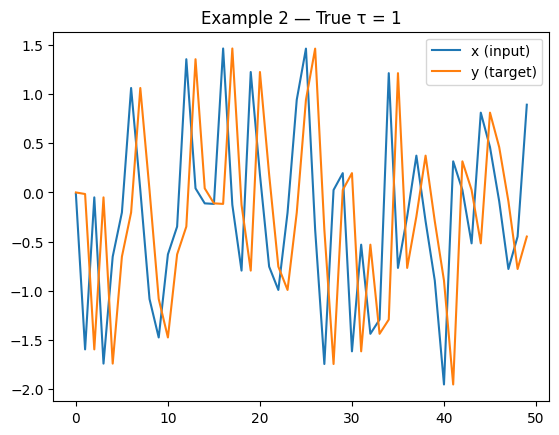

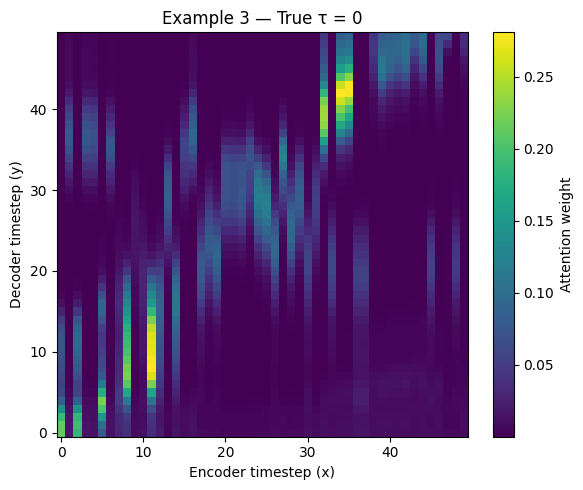

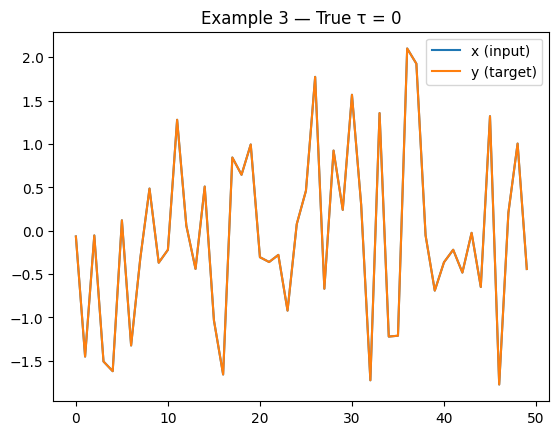

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

# ======================================================
# 1. Device Setup
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ======================================================
# 2. Synthetic Data Generator (White Noise with Variable τ)
# ======================================================
def generate_batch(batch_size, seq_len, tau_min=0, tau_max=10, obs_noise=0.0):
    """
    Each example in the batch has white noise input x, and target y = x shifted by a random τ.
    """
    x_batch = []
    y_batch = []
    tau_list = []

    for _ in range(batch_size):
        x = torch.randn(seq_len)
        tau = torch.randint(tau_min, tau_max + 1, (1,)).item()
        y = torch.roll(x, shifts=tau, dims=0)
        y[:tau] = 0.0
        if obs_noise > 0:
            x = x + obs_noise * torch.randn_like(x)
            y = y + obs_noise * torch.randn_like(y)
        x_batch.append(x)
        y_batch.append(y)
        tau_list.append(tau)

    x_batch = torch.stack(x_batch).unsqueeze(-1)  # (B, T, 1)
    y_batch = torch.stack(y_batch).unsqueeze(-1)
    tau_list = torch.tensor(tau_list)
    return x_batch, y_batch, tau_list

# ======================================================
# 3. Positional Encoding
# ======================================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# ======================================================
# 4. Transformer Model Setup
# ======================================================
seq_len = 50
tau_min, tau_max = 0, 10
batch_size = 64
n_batches = 3000
d_model = 64
nhead = 4
num_layers = 2

encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers).to(device)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers).to(device)
in_proj = nn.Linear(1, d_model).to(device)
out_proj = nn.Linear(d_model, 1).to(device)
pos_enc = PositionalEncoding(d_model).to(device)

optimizer = optim.Adam(
    list(encoder.parameters()) +
    list(decoder.parameters()) +
    list(in_proj.parameters()) +
    list(out_proj.parameters()),
    lr=1e-3
)
loss_fn = nn.MSELoss()

# ======================================================
# 5. Training Loop (Variable τ White Noise)
# ======================================================
loss_history = []
print("Training with variable τ (white noise)...")

for step in range(n_batches):
    x, y, _ = generate_batch(batch_size, seq_len, tau_min, tau_max, obs_noise=0.0)
    x = x.to(device)
    y = y.to(device)

    x_emb = pos_enc(in_proj(x))
    y_zeros = torch.zeros_like(x)
    y_emb = pos_enc(in_proj(y_zeros))

    mem = encoder(x_emb)
    out = decoder(y_emb, mem)
    y_pred = out_proj(out)

    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (step + 1) % 500 == 0:
        print(f"Step {step+1}/{n_batches}, Loss: {loss.item():.6f}")

plt.figure()
plt.plot(loss_history)
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.title("Training Loss (Variable τ — White Noise)")
plt.show()

# ======================================================
# 6. Cross-Attention Visualization for Multiple Examples
# ======================================================
encoder.eval()
decoder.eval()

n_examples_to_visualize = 4
x_test, y_test, taus = generate_batch(n_examples_to_visualize, seq_len, tau_min, tau_max, obs_noise=0.0)
x_test = x_test.to(device)
y_test = y_test.to(device)

x_emb = pos_enc(in_proj(x_test))
y_emb = pos_enc(in_proj(torch.zeros_like(x_test)))

mem = encoder(x_emb)

layer = decoder.layers[0]
tgt = y_emb
tgt2 = layer.self_attn(tgt, tgt, tgt, need_weights=False)[0]
tgt = layer.norm1(tgt + layer.dropout1(tgt2))
tgt2, attn = layer.multihead_attn(
    tgt, mem, mem,
    need_weights=True,
    average_attn_weights=True
)

attn_map = attn.detach().cpu().numpy()  # (B, T_dec, T_enc)

for i in range(n_examples_to_visualize):
    plt.figure(figsize=(6, 5))
    plt.imshow(attn_map[i], aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Attention weight')
    plt.xlabel('Encoder timestep (x)')
    plt.ylabel('Decoder timestep (y)')
    plt.title(f'Example {i} — True τ = {taus[i].item()}')
    plt.tight_layout()
    plt.show()

    # Optional: visualize input/target
    plt.figure()
    plt.plot(x_test[i].cpu().numpy(), label='x (input)')
    plt.plot(y_test[i].cpu().numpy(), label='y (target)')
    plt.legend()
    plt.title(f'Example {i} — True τ = {taus[i].item()}')
    plt.show()